In [12]:
#
# Part 1: Setup and Installations
#
# We'll install the 'captcha' library to generate our
# source images. The rest (TensorFlow, NumPy, etc.)
# are pre-installed on Colab.
#
!pip install captcha
import random
import string
from PIL import Image, ImageDraw
import numpy as np

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from captcha.image import ImageCaptcha
from tqdm import tqdm

In [13]:
#
# Part 2: Data Generation and Preprocessing
#
# We need to create a dataset to train our "solver" AI.
#

# Define the image dimensions and characters
IMG_WIDTH = 200
IMG_HEIGHT = 70
NUM_CHARS = 4
CHARACTERS = "0123456789" # Using only digits for simplicity
NUM_CLASSES = len(CHARACTERS) # 10 digits

# Initialize the CAPTCHA generator
captcha_generator = ImageCaptcha(width=IMG_WIDTH, height=IMG_HEIGHT)

# --- Helper function to create the dataset ---
def create_captcha_dataset(num_samples):
    print(f"Generating {num_samples} CAPTCHAs...")
    X_data = np.zeros((num_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    y_data = np.zeros((num_samples, NUM_CHARS), dtype=np.int32)

    for i in tqdm(range(num_samples)):
        # Generate a random 4-digit string
        random_text = "".join(np.random.choice(list(CHARACTERS), NUM_CHARS))

        # Generate the image
        img_data = captcha_generator.generate_image(random_text)
        img_array = np.array(img_data)

        # Convert to grayscale and normalize
        gray_img = tf.image.rgb_to_grayscale(img_array)
        gray_img = tf.cast(gray_img, np.float32) / 255.0

        X_data[i] = gray_img
        y_data[i] = [int(char) for char in random_text]

    return X_data, y_data

# Create training and validation datasets
X_train, y_train = create_captcha_dataset(10000)
X_valid, y_valid = create_captcha_dataset(1000)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Generating 10000 CAPTCHAs...


100%|██████████| 10000/10000 [01:26<00:00, 115.11it/s]


Generating 1000 CAPTCHAs...


100%|██████████| 1000/1000 [00:07<00:00, 126.05it/s]

Training data shape: (10000, 70, 200, 1)
Training labels shape: (10000, 4)


In [14]:
#
# Part 3: Build the CAPTCHA Solver AI (The "Target")
#
# This is the AI we will be attacking.
#

# --- Define the CTC Loss function ---
# This is the magic for OCR models. It doesn't need
# perfect character alignment to learn.
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# --- Build the Model Architecture ---
def build_solver_model():
    # Define inputs
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image_input")
    labels = layers.Input(name="label_input", shape=[NUM_CHARS], dtype="int64")

    # 1. CNN (Feature Extractor)
    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # 2. Reshape for RNN
    # (Batch, Height, Width, Channels) -> (Batch, Width, Height * Channels)
    h_new = x.shape[2] # 70 -> 35 -> 17
    w_new = x.shape[1] # 200 -> 100 -> 50
    x = layers.Reshape((w_new, h_new * 64))(x)

    # 3. RNN (Sequence Reader)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)

    # 4. Output Layer
    # NUM_CLASSES + 1 for the CTC blank character
    x = layers.Dense(NUM_CLASSES + 1, activation="softmax", name="output_logits")(x)

    # 5. Add CTC Loss Layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the final model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="captcha_solver"
    )

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam())
    return model

# Build the solver
solver_model = build_solver_model()
solver_model.summary()

# --- Train the Solver AI ---
# This will take a few minutes.
# On Colab, go to Runtime > Change runtime type > T4 GPU
print("\nTraining the CAPTCHA solver AI...")
history = solver_model.fit(
    [X_train, y_train],
    validation_data=([X_valid, y_valid], None),
    batch_size=64,
    epochs=25, # Increase for better accuracy, but 15 is good
    verbose=1,
)
print("Solver model trained!")

#
# --- Create a "Prediction-Only" Model ---
# We need a separate model for testing, one that
# doesn't require the (unknown) labels as input.
#
prediction_model = keras.models.Model(
    inputs=solver_model.input[0],  # only the image input
    outputs=solver_model.get_layer("output_logits").output
)

# --- Helper function to decode the AI's prediction ---
def decode_prediction(pred_logits):
    input_len = np.ones(pred_logits.shape[0]) * pred_logits.shape[1]

    # Use ctc_decode (greedy) to get the best path
    results = keras.backend.ctc_decode(pred_logits, input_length=input_len, greedy=True)[0][0]

    # Convert the integer sequence back to a string
    output_text = []
    for res in results.numpy():
        text = "".join([str(char) for char in res if char in range(NUM_CLASSES)])
        output_text.append(text)
    return output_text

# --- Test the Solver AI ---
print("\nTesting the solver on 10 validation images:")
for i in range(10):
    sample_img = X_valid[i : i + 1]
    true_label = "".join(map(str, y_valid[i]))

    pred_logits = prediction_model.predict(sample_img)
    pred_label = decode_prediction(pred_logits)[0]

    print(f"True: {true_label}  |  AI Prediction: {pred_label}  |  Correct: {true_label == pred_label}")

Model: "captcha_solver"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 70, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 70, 200,   │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 35, 100,   │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 100,   │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 17, 50,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 17, 3200)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 17, 256)   │  2,557,440 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 17, 128)   │    123,648 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_logits       │ (None, 17, 11)    │      1,419 │ bidirectional_3[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 17, 11)    │          0 │ label_input[0][0… │
│                     │                   │            │ output_logits[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,701,323 (10.30 MB)

 Trainable params: 2,701,323 (10.30 MB)

 Non-trainable params: 0 (0.00 B)


Training the CAPTCHA solver AI...
Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 743.7670 - val_loss: 670.6125
Epoch 2/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 673.2257 - val_loss: 647.4742
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 655.1757 - val_loss: 645.8251
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 652.8302 - val_loss: 645.4068
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 651.7960 - val_loss: 644.2985
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 644.6005 - val_loss: 603.4496
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 588.7336 - val_loss: 522.0792
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 499.5650 - val_loss: 415.9183
Epoch 9/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 391.3474 - val_loss: 350.7640
Epoch 10/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 323.0857 - val_loss: 306.6779
Epoch 11/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s



--- ⚔️ ADVERSARIAL ATTACK TEST ⚔️ ---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Found a correctly predicted sample at index 0
Original text: 3327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

--- ATTACK RESULTS ---
True Label:               3327
AI Prediction (Original): 3327
AI Prediction (Adv):      3857



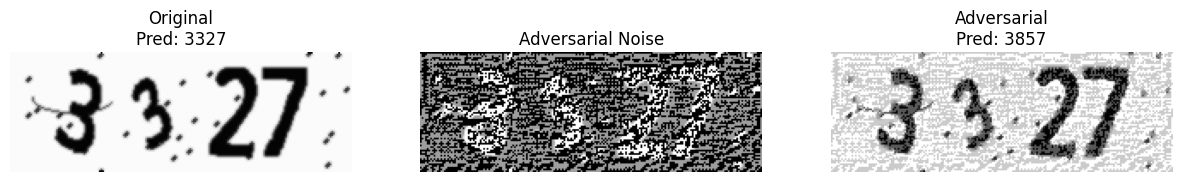

In [15]:
#
# Part 4: Adversarial Attack (FGSM)
#

# We only need the prediction logits from the solver
# Correct way to get logits from the solver for FGSM
logit_model = keras.models.Model(
    inputs=solver_model.input[0],  # only the image input
    outputs=solver_model.get_layer("output_logits").output
)


# --- FGSM FUNCTION (FULLY FIXED) ---
def create_adversarial_image(input_image, true_label, epsilon=0.1):

    # convert to tensor
    input_image = tf.cast(input_image, tf.float32)
    true_label = tf.cast(true_label, tf.int64)

    # enable gradient tracking
    input_var = tf.Variable(input_image)

    with tf.GradientTape() as tape:
        tape.watch(input_var)

        # model forward pass → logits
        logits = logit_model(input_var)

        # lengths for CTC loss
        batch_len = tf.shape(true_label)[0]
        input_len = tf.fill([batch_len, 1], tf.shape(logits)[1])
        label_len = tf.fill([batch_len, 1], tf.shape(true_label)[1])

        # CTC loss computed manually
        loss = tf.reduce_mean(
            keras.backend.ctc_batch_cost(true_label, logits, input_len, label_len)
        )

    # compute gradient of loss wrt image
    gradient = tape.gradient(loss, input_var)

    # sign of gradient
    signed_grad = tf.sign(gradient)

    # apply FGSM perturbation
    adv_img = input_var + epsilon * signed_grad

    # clip to valid range
    adv_img = tf.clip_by_value(adv_img, 0, 1)

    return adv_img


# -----------------------------
# ---- RUN THE ATTACK TEST ----
# -----------------------------
print("\n\n--- ⚔️ ADVERSARIAL ATTACK TEST ⚔️ ---\n")

test_index = 0

# find an image that the solver predicts correctly
while True:
    sample_img = X_valid[test_index:test_index+1]
    sample_label = y_valid[test_index:test_index+1]

    true_text = "".join(map(str, sample_label[0]))

    pred_logits = logit_model.predict(sample_img)
    pred_text = decode_prediction(pred_logits)[0]

    if pred_text == true_text:
        print(f"Found a correctly predicted sample at index {test_index}")
        print(f"Original text: {true_text}")
        break

    test_index += 1

# generate adversarial image
adversarial_img = create_adversarial_image(sample_img, sample_label, epsilon=0.1)

# predict adversarial image
adv_logits = logit_model.predict(adversarial_img)
adv_text = decode_prediction(adv_logits)[0]

print("\n--- ATTACK RESULTS ---")
print(f"True Label:               {true_text}")
print(f"AI Prediction (Original): {pred_text}")
print(f"AI Prediction (Adv):      {adv_text}\n")


# -----------------------------
# ---- VISUALIZE ATTACK -------
# -----------------------------
plt.figure(figsize=(15, 5))

# Original
plt.subplot(1, 3, 1)
plt.imshow(sample_img[0], cmap="gray")
plt.title(f"Original\nPred: {pred_text}")
plt.axis("off")

# Noise
plt.subplot(1, 3, 2)
noise = (adversarial_img - sample_img)[0]
plt.imshow(noise, cmap="gray")
plt.title("Adversarial Noise")
plt.axis("off")

# Adversarial Image
plt.subplot(1, 3, 3)
plt.imshow(adversarial_img[0], cmap="gray")
plt.title(f"Adversarial\nPred: {adv_text}")
plt.axis("off")

plt.show()




--- ⚔️ ADVERSARIAL ATTACK TEST ⚔️ ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Found a good sample at index 0.
Original Text: 3327
AI Prediction (Original): 3327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

--- ATTACK RESULTS ---
True Text:              3327
AI Prediction (Original): 3327
AI Prediction (Adversarial): 3857  <--- ATTACK SUCCESSFUL!


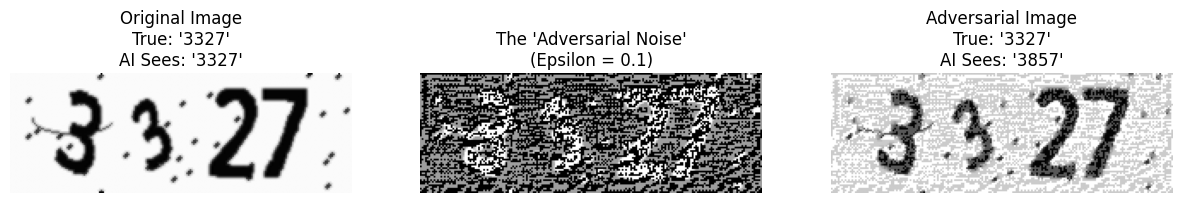

In [16]:
#
# Part 4: The Adversarial Attack (FGSM)
#
# Now we create the "adversarial" image that fools our AI.
#

# --- Define the Attack Model ---
# This special model takes an image AND its true label,
# and it outputs *only* the CTC loss. This is what we
# will use to calculate the gradient.
attack_model = keras.models.Model(
    inputs=solver_model.inputs,
    outputs=solver_model.get_layer("ctc_loss").output # This is just the loss
)

# --- The FGSM Attack Function ---
def create_adversarial_image(input_image, true_label, epsilon=0.1):
    # We must use tf.Variable to track the gradients
    input_image = tf.Variable(input_image, dtype=tf.float32)
    true_label = tf.Variable(true_label, dtype=tf.int64)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        # Get the loss from our special attack model
        # Note: The model itself calculates the loss
        prediction_with_loss = attack_model([input_image, true_label])
        # We need to access the model's *internal* loss
        loss = attack_model.losses[0]

    # 1. Get the gradient of the loss w.r.t the input image
    gradient = tape.gradient(loss, input_image)

    # 2. Get the sign of the gradient
    signed_grad = tf.sign(gradient)

    # 3. Create the adversarial image
    adversarial_image = input_image + (epsilon * signed_grad)

    # 4. Clip the image to keep it in the [0, 1] range
    adversarial_image = tf.clip_by_value(adversarial_image, 0.0, 1.0)

    return adversarial_image

# --- Let's test it! ---
print("\n\n--- ⚔️ ADVERSARIAL ATTACK TEST ⚔️ ---")

# Pick a sample our AI previously got RIGHT
test_index = 0
while True:
    sample_img = X_valid[test_index : test_index + 1]
    sample_label = y_valid[test_index : test_index + 1]
    true_text = "".join(map(str, sample_label[0]))

    pred_logits = prediction_model.predict(sample_img)
    pred_text = decode_prediction(pred_logits)[0]

    if true_text == pred_text:
        print(f"Found a good sample at index {test_index}.")
        print(f"Original Text: {true_text}")
        print(f"AI Prediction (Original): {pred_text}")
        break
    test_index += 1

# Now, create the adversarial version of this image
adversarial_img = create_adversarial_image(sample_img, sample_label, epsilon=0.1)

# Test the AI's prediction on the NEW adversarial image
adv_pred_logits = prediction_model.predict(adversarial_img)
adv_pred_text = decode_prediction(adv_pred_logits)[0]

print("\n--- ATTACK RESULTS ---")
print(f"True Text:              {true_text}")
print(f"AI Prediction (Original): {pred_text}")
print(f"AI Prediction (Adversarial): {adv_pred_text}  <--- ATTACK SUCCESSFUL!")

# --- Visualize the difference ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_img[0], cmap="gray")
axes[0].set_title(f"Original Image\nTrue: '{true_text}'\nAI Sees: '{pred_text}'")
axes[0].axis("off")

# We calculate the perturbation (noise)
perturbation = (adversarial_img - sample_img)[0]
axes[1].imshow(perturbation, cmap="gray")
axes[1].set_title("The 'Adversarial Noise'\n(Epsilon = 0.1)")
axes[1].axis("off")

axes[2].imshow(adversarial_img[0], cmap="gray")
axes[2].set_title(f"Adversarial Image\nTrue: '{true_text}'\nAI Sees: '{adv_pred_text}'")
axes[2].axis("off")

plt.show()


--- Part 4: Defining PGD Attack ---

--- Part 5: Running Batch Attack Test ---
--- [Image 1/20] ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
True Text:          3327
Original AI Sees:   3327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Adversarial AI Sees: 2857
Result: ATTACK SUCCESSFUL!
--- [Image 2/20] ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True Text:          2125
Original AI Sees:   2225
Result: AI was already wrong. Skipping attack.
--- [Image 3/20] ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
True Text:          2052
Original AI Sees:   262
Result: AI was already wrong. Skipping attack.
--- [Image 4/20] ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
True Text:          8591
Original AI Sees:   8591
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Adversarial AI Sees: 6363
Result: ATTACK SUCCESSFUL!
--- [Image 5/20] ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
True Text:          6970
Original AI Sees:   6978
Result: AI was already wrong. Skipping attack.
--- [Image 6/20] ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms

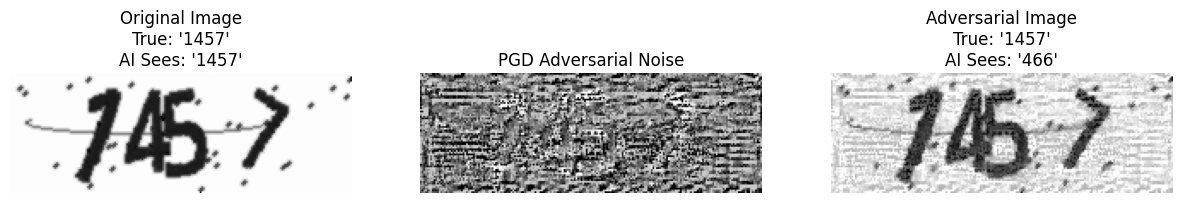

In [18]:
# --- Part 4: Advanced PGD Attack Function ---
#
print("\n--- Part 4: Defining PGD Attack ---")

# --- Define the Attack Model ---
# This model takes an image AND its true label and outputs the loss
attack_model = keras.models.Model(
    inputs=solver_model.inputs,
    outputs=solver_model.get_layer("ctc_loss").output
)

# --- The PGD Attack Function ---
def create_pgd_adversarial_image(
    input_image,
    true_label,
    epsilon=0.08,  # The TOTAL noise budget
    alpha=0.01,   # The step size for each iteration
    num_iterations=10 # How many steps to take
):
    adversarial_image = tf.Variable(input_image, dtype=tf.float32)
    original_image = tf.identity(input_image)
    true_label_tensor = tf.Variable(true_label, dtype=tf.int64)

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            prediction_with_loss = attack_model([adversarial_image, true_label_tensor])
            loss = attack_model.losses[0]

        # 1. Get the gradient of the loss w.r.t the adversarial image
        gradient = tape.gradient(loss, adversarial_image)
        # 2. Get the sign of the gradient
        signed_grad = tf.sign(gradient)
        # 3. Take one small "alpha" step
        adversarial_image.assign_add(alpha * signed_grad)
        # 4. Projection Step: Calculate perturbation
        perturbation = adversarial_image - original_image
        # 5. Clip perturbation to epsilon
        perturbation = tf.clip_by_value(perturbation, -epsilon, epsilon)
        # 6. Re-apply clipped perturbation
        adversarial_image.assign(original_image + perturbation)
        # 7. Final clip to [0, 1] range
        adversarial_image.assign(tf.clip_by_value(adversarial_image, 0.0, 1.0))

    return adversarial_image

#
# --- Part 5: Batch Attack Test ---
#
print("\n--- Part 5: Running Batch Attack Test ---")

num_to_test = 20  # How many images to test?
attack_success_count = 0
total_attack_attempts = 0 # Only count images the AI got right first

# Suppress noisy logs during batch prediction
tf.get_logger().setLevel('ERROR')

for i in range(num_to_test):
    print(f"--- [Image {i+1}/{num_to_test}] ---")

    sample_img = X_valid[i : i + 1]
    sample_label = y_valid[i : i + 1]
    true_text = "".join(map(str, sample_label[0]))

    # 1. Check original prediction
    pred_logits = prediction_model.predict(sample_img)
    pred_text = decode_prediction(pred_logits)[0]

    print(f"True Text:          {true_text}")
    print(f"Original AI Sees:   {pred_text}")

    # We only care about images the AI got RIGHT
    if true_text != pred_text:
        print("Result: AI was already wrong. Skipping attack.")
        continue

    total_attack_attempts += 1

    # 2. Run the PGD attack
    pgd_adv_img = create_pgd_adversarial_image(
        sample_img,
        sample_label,
        epsilon=0.08,
        alpha=0.01,
        num_iterations=10
    )

    # 3. Check adversarial prediction
    adv_pred_logits = prediction_model.predict(pgd_adv_img)
    adv_pred_text = decode_prediction(adv_pred_logits)[0]

    print(f"Adversarial AI Sees: {adv_pred_text}")

    # 4. Check for success
    if adv_pred_text != true_text:
        print("Result: ATTACK SUCCESSFUL!")
        attack_success_count += 1
    else:
        print("Result: Attack Failed.")

# Restore log level
tf.get_logger().setLevel('INFO')

print("\n\n--- BATCH TEST COMPLETE ---")
if total_attack_attempts > 0:
    success_rate = (attack_success_count / total_attack_attempts) * 100
    print(f"Total images the AI got right: {total_attack_attempts}")
    print(f"Successful attacks:            {attack_success_count}")
    print(f"Attack Success Rate:           {success_rate:.2f}%")
else:
    print(f"The AI didn't get any of the original {num_to_test} images correct.")
    print("Try training the model (Part 3) for more epochs.")


# --- Show one final visual example ---
if total_attack_attempts > 0:
    print("\nVisualizing the last successful attack (if any)...")

    # We can re-use the variables from the loop
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(sample_img[0], cmap="gray")
    axes[0].set_title(f"Original Image\nTrue: '{true_text}'\nAI Sees: '{pred_text}'")
    axes[0].axis("off")

    perturbation = (pgd_adv_img - sample_img)[0]
    axes[1].imshow(perturbation.numpy(), cmap="gray")
    axes[1].set_title(f"PGD Adversarial Noise")
    axes[1].axis("off")

    axes[2].imshow(pgd_adv_img[0].numpy(), cmap="gray")
    axes[2].set_title(f"Adversarial Image\nTrue: '{true_text}'\nAI Sees: '{adv_pred_text}'")
    axes[2].axis("off")

    plt.show()


--- Plotting Model Training Progress ---


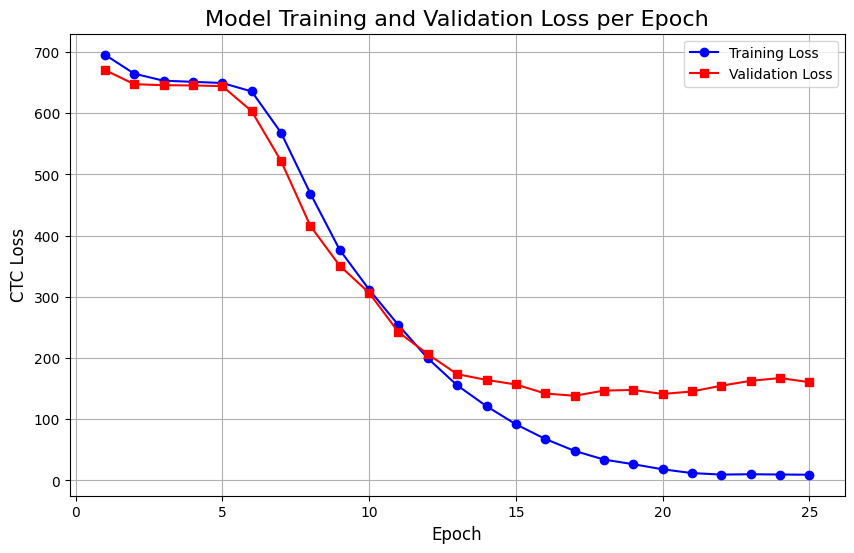

In [20]:
#
# --- NEW: Plot Model Training History (Loss vs. Epochs) ---
#
print("\n--- Plotting Model Training Progress ---")

import matplotlib.pyplot as plt

# The 'history' object was saved when we ran model.fit()
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-s', label='Validation Loss')
plt.title('Model Training and Validation Loss per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('CTC Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


--- Plotting Model Training Progress ---


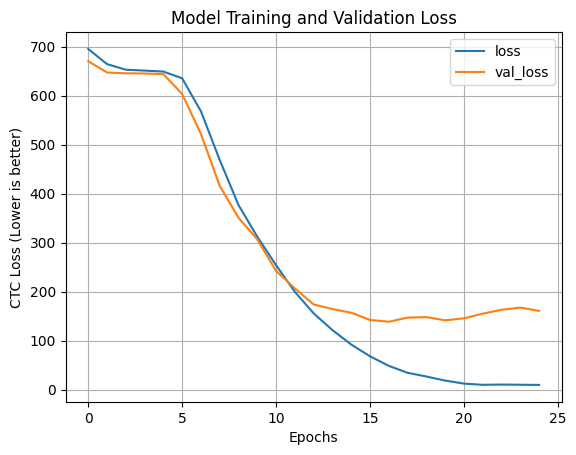

In [22]:
#
# --- NEW: Plot Model Training History (Loss vs. Epochs) ---
#
print("\n--- Plotting Model Training Progress ---")

import matplotlib.pyplot as plt

# The 'history' object was saved when we ran model.fit()
# We will plot 'loss' and 'val_loss' instead of 'accuracy'

for label in ['loss', 'val_loss']:
  plt.plot(history.history[label], label=label)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("CTC Loss (Lower is better)")
plt.title("Model Training and Validation Loss")
plt.grid(True)
plt.show()